In [2]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [25]:
# Target Users
target_users = ("@BBCBreaking", "@CBSNews", "@cnnbrk", "@FoxNews", "@nytimes")

# List to hold sentiment
sentiments = []

# Loop through all target users
for target in target_users:
    
    # Variables for max_id
    oldest_tweet = None
    
    # Counter
    counter = 1
    
    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(5):
        
        # Get all tweets from home feed
        public_tweets = api.user_timeline(target, result_type="recent", max_id = oldest_tweet)
        
        # Loop through all tweets
        for tweet in public_tweets:
            
            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            
            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            oldest_tweet = tweet["id"] - 1
            
            # Add sentiments for each tweet into a list
            sentiments.append({"Account": target,
                               "Tweet": tweet["text"],
                               "Date": tweet["created_at"],
                               "Compound": compound,
                               "Positive": pos,
                               "Negative": neg,
                               "Neutral": neu,
                               "Tweets Ago": counter,})
            
            # Add to counter
            counter += 1

In [26]:
# Convert sentiments to DataFrame
sentiment_pd = pd.DataFrame.from_dict(sentiments)
sentiment_pd = sentiment_pd[["Account", "Tweet", "Date", "Compound", "Positive", "Neutral", "Negative", "Tweets Ago"]]

# Export the data in the DataFrame into a CSV file
sentiment_pd.to_csv("New_Mood_Output.csv")
sentiment_pd.head()

,Account,Tweet,Date,Compound,Positive,Neutral,Negative,Tweets Ago
0,@BBCBreaking,Five dead and five injured after car and minib...,Fri Jul 27 05:53:04 +0000 2018,-0.8658,0.000,0.553,0.447,1
1,@BBCBreaking,North Korea has returned the remains of US tro...,Fri Jul 27 01:59:48 +0000 2018,-0.8555,0.000,0.656,0.344,2
2,@BBCBreaking,"More than 1,800 migrant children in US reunite...",Thu Jul 26 23:04:29 +0000 2018,0.0000,0.000,1.000,0.000,3
3,@BBCBreaking,Former cricketer Imran Khan claims victory in ...,Thu Jul 26 12:17:23 +0000 2018,-0.3182,0.000,0.874,0.126,4
4,@BBCBreaking,"BBC agrees to pay Sir Cliff Richard £850,000 w...",Thu Jul 26 09:56:02 +0000 2018,0.2263,0.152,0.783,0.065,5


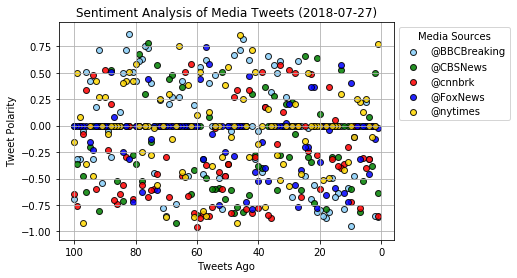

In [126]:
# Create scatter plot
color_map = {"@BBCBreaking": "lightskyblue",
             "@CBSNews": "green",
             "@cnnbrk": "red",
             "@FoxNews": "blue",
             "@nytimes": "gold"}

for target in target_users:
    df = sentiment_pd.loc[sentiment_pd["Account"] == target]
    plt.scatter(df["Tweets Ago"], df["Compound"], label=target,
                facecolor=color_map[target], edgecolor="black", alpha=0.85)

# Incorporate the other graph properties
plt.legend(target_users, title="Media Sources", bbox_to_anchor = (1,1))
date = datetime.now().strftime("%Y-%m-%d")
plt.title(f"Sentiment Analysis of Media Tweets ({date})")
plt.xlim([x_vals.max()+5,x_vals.min()-5])
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.grid()

# Save Figure
plt.savefig("News_Mood_Scatter.png")

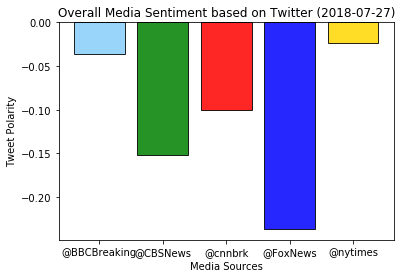

In [128]:
# Create bar plot
sentiment_pd_group = sentiment_pd.groupby("Account").mean()

x_axis = np.arange(0, len(target_users))
tick_locations = []
for x in x_axis:
    tick_locations.append(x)

plt.bar(x_axis, sentiment_pd_group["Compound"], alpha=0.85,
        color=("lightskyblue", "green", "red", "blue", "gold"), edgecolor="black")
plt.xticks(tick_locations, target_users)

plt.title(f"Overall Media Sentiment based on Twitter ({date})")
plt.xlabel("Media Sources")
plt.ylabel("Tweet Polarity")

# Save Figure
plt.savefig("News_Mood_Bar.png")